In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from myst_nb import glue as default_glue
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import savefig
from pkg.plot import plot_density, plot_pvalues, set_theme
from pkg.stats import erdos_renyi_test, stochastic_block_test

DISPLAY_FIGS = True

FILENAME = "kc_minus"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, pad_inches=0, bbox_inches="tight", **kwargs)

    glue(name, fig, prefix="fig")

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, prefix=None):
    savename = f"{FILENAME}-{name}"
    if prefix is not None:
        savename = prefix + ":" + savename
    default_glue(savename, var, display=False)

In [2]:
t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

# Remove kenyon cells
left_nodes["inds"] = range(len(left_nodes))
sub_left_nodes = left_nodes[left_nodes[GROUP_KEY] != "KCs"]
sub_left_inds = sub_left_nodes["inds"].values
right_nodes["inds"] = range(len(right_nodes))
sub_right_nodes = right_nodes[right_nodes[GROUP_KEY] != "KCs"]
sub_right_inds = sub_right_nodes["inds"].values

sub_left_adj = left_adj[np.ix_(sub_left_inds, sub_left_inds)]
sub_right_adj = right_adj[np.ix_(sub_right_inds, sub_right_inds)]
sub_left_labels = sub_left_nodes[GROUP_KEY]
sub_right_labels = sub_right_nodes[GROUP_KEY]

## Methods

from pkg.utils import sample_toy_networks, get_toy_palette
from pkg.plot import networkplot_simple


A1, A2, node_data = sample_toy_networks()
palette = get_toy_palette()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

ax = axs[0, 0]
networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")
ax.set(title="Remove Kenyon cells")

ax = axs[1, 0]
networkplot_simple(A2, node_data, palette=palette, ax=ax, group=True)
x, y = node_data[node_data["labels"] == 1][["x", "y"]].mean()
ax.text(x, y, "X", color="darkred", fontsize=80, va="center", ha="center")

from giskard.plot import merge_axes

ax = merge_axes(fig, axs, rows=None, cols=1)
ax.axis("off")
ax.set_title("Re-run all tests")
plt.tight_layout()

gluefig("kc_minus_methods", fig)

## ER test

6.949928675622712e-27


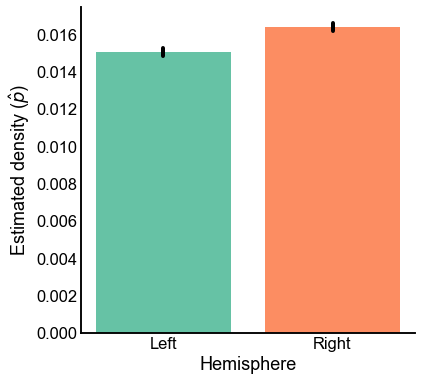

In [3]:

stat, pvalue, misc = erdos_renyi_test(sub_left_adj, sub_right_adj)
print(pvalue)
glue("er_pvalue", pvalue)

fig, ax = plot_density(misc, palette=network_palette)
gluefig("densities", fig)

## SBM test

0.0026526463992977527


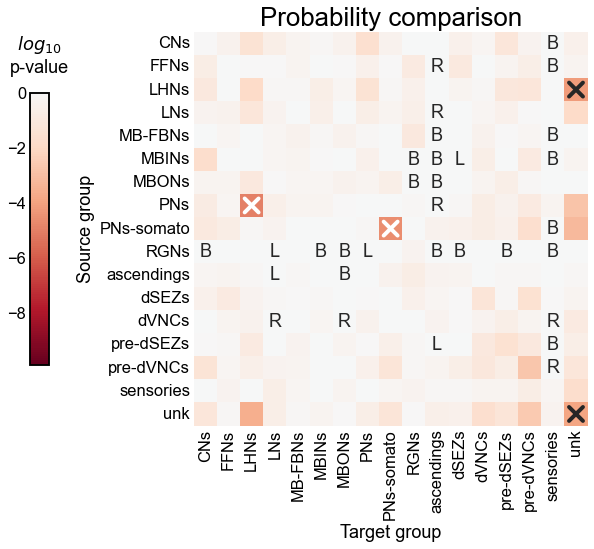

In [4]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    combine_method="tippett",
)
print(pvalue)
glue("sbm_pvalue", pvalue)

fig, ax = plot_pvalues(misc)
gluefig("sbm_pvalues", fig)

## aSBM test

0.43021496585932206


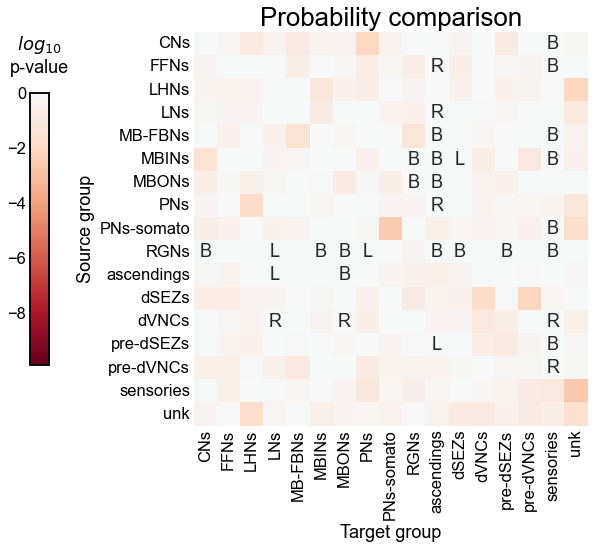

In [5]:

stat, pvalue, misc = stochastic_block_test(
    sub_left_adj,
    sub_right_adj,
    labels1=sub_left_labels,
    labels2=sub_right_labels,
    method="fisher",
    density_adjustment=True,
    combine_method="tippett",
)
print(pvalue)
glue("asbm_pvalue", pvalue)
glue("asbm_pvalue_formatted", f"{pvalue:.2g}")

fig, ax = plot_pvalues(misc)
gluefig("asbm_pvalues", fig)

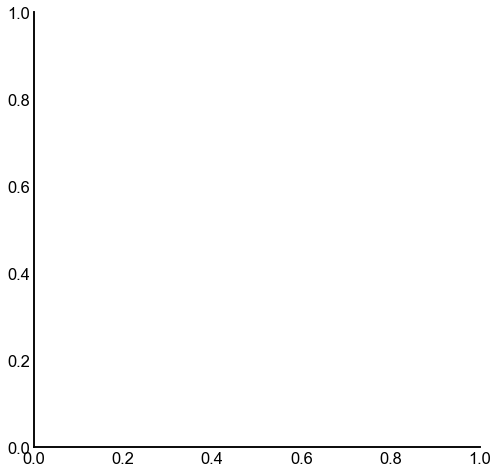

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
gluefig("box", fig)

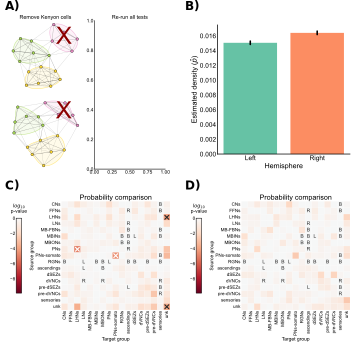

In [7]:

from svgutils.compose import SVG, Figure, Panel, Text
from pkg.io import FIG_PATH
import ast

total_width = 1000
total_height = 1500

FIG_PATH = FIG_PATH / FILENAME

fontsize = 35


def get_true_width_height(svg):
    if "transform" in svg.root.attrib:
        transform = svg.root.attrib["transform"]
        ind = transform.rfind("scale")
        transform_scale = transform[ind:].strip("scale").strip(" ").replace(" ", ",")
        transform_tup = ast.literal_eval(transform_scale)
    else:
        transform_tup = (1.0, 1.0)
    return svg._width.value * transform_tup[0], svg._height.value * transform_tup[1]


class NotStupidSVG(SVG):
    @property
    def height(self):
        _, height = get_true_width_height(self)
        return height

    @property
    def width(self):
        width, _ = get_true_width_height(self)
        return width

    def set_width(self, width):
        current_width = self.width
        scaler = width / current_width
        self.scale(scaler)


# class NotStupidPanel(Panel):
#     @property
#     def height(self):
#         return self.root.getchildren().height
#         # _, height = get_true_width_height(self)
#         # return height

#     @property
#     def width(self):
#         width, _ = get_true_width_height(self)
#         return width

#     def set_width(self, width):
#         current_width = self.width
#         scaler = width / current_width
#         self.scale(scaler)


methods = NotStupidSVG(FIG_PATH / "kc_minus_methods.svg")
methods.set_width(200)
methods.move(10, 15)
methods_panel = Panel(methods, Text("A)", 5, 10, size=12, weight="bold"))

er = NotStupidSVG(FIG_PATH / "densities.svg")
er.set_width(200)
er.move(10, 25)
er_panel = Panel(er, Text("B)", 5, 10, size=12, weight="bold"))
er_panel.move(methods.width * 0.9, 0)

sbm = NotStupidSVG(FIG_PATH / "sbm_pvalues.svg")
sbm.set_width(200)
sbm.move(10, 15)
sbm_panel = Panel(sbm, Text("C)", 5, 10, size=12, weight="bold"))
sbm_panel.move(0, methods.height * 0.9)

asbm = NotStupidSVG(FIG_PATH / "asbm_pvalues.svg")
asbm.set_width(200)
asbm.move(10, 15)
asbm_panel = Panel(asbm, Text("D)", 5, 10, size=12, weight="bold"))
asbm_panel.move(methods.width * 0.9, methods.height * 0.9)

# width, _ = get_true_width_height(methods)
# print(width)
# set_width(methods, 200)

# er = SVG(FIG_PATH / "densities.svg")
# set_width(er, 200)
# er.move(), 0)


# text = Text("here", methods.width, 100, size=20)
# text = Text("here", methods.width * 0.8, 100, size=20)

# sbm = SVG(FIG_PATH / 'sbm_pvalues.svg')
# set_width(er, 1000)

# # asbm = SVG(FIG_PATH / 'asbm_pvalues.svg')
# # set_width(er, 1000)


fig = Figure(
    (methods.width + er.width) * 0.9,
    (methods.height + sbm.height) * 0.9,
    methods_panel,
    er_panel,
    sbm_panel,
    asbm_panel,
)
fig.save(FIG_PATH / "composite.svg")
fig


# #%%
# fig, axs = plt.subplot_mosaic(
#     [["A)", "B)"], ["C)", "D)"]], figsize=(10, 10), constrained_layout=True
# )
# for label, ax in axs.items():
#     # ax.set_title("Normal Title", fontstyle="italic")
#     ax.set_title(label, loc="left", fontsize="large", fontweight="bold")
#     ax.set(xticks=[], yticks=[])

# axs[0, 0].remove()
# fig.add_subplot()

# fig.set_facecolor("w")

# # #%%

# import pylustrator as pyl

# kc_minus = pyl.load(FIG_PATH / "box.svg")

# plt.show()